In [1]:
# import PyTorch
import torch

# standard DS stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
# embed static images in the ipynb
%matplotlib inline 

# neural network package
import torch.nn as nn 
import torch.nn.functional as F

In [2]:
def plot_V_info(V_info):
    """[summary]

    Args:
        V_info ([type]): [description]
    """
    global fig, ax
    figscale, defaultSize = 2, np.array([8, 6])
    fig, ax = plt.subplots(nrows=2, ncols=2 ,figsize=figscale*defaultSize)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.4, left = 0.1, right = 0.7, bottom = 0.1, top = 0.9) 
    
    ax[0,0].hist(V_info["avg"])
    ax[0,0].set(xlabel="V_avg", ylabel="batches", title="Avg(Var)")
    
    ax[1,0].hist(V_info["std"])
    ax[1,0].set(xlabel="V_std", ylabel="batches", title="Std(Var)")

    ax[0,1].hist(V_info["max"])
    ax[0,1].set(xlabel="V_max", ylabel="batches", title="Max(Var)")

    ax[1,1].hist(V_info["min"])
    ax[1,1].set(xlabel="V_min", ylabel="batches", title="Min(Var)")

    plt.show()

def varAnalysis(X, verbose=False):
    V = np.var(X, axis=0)
    V_avg, V_std = np.mean(V), np.std(V)
    V_max, V_min = np.max(V), np.min(V)
    
    if verbose == True:
        print(f"V_avg: {np.mean(V):.3f}")    
        print(f"V_std: {np.std(V):.3f}")
        print(f"V_max: {np.max(V):.3f}")
        print(f"V_min: {np.min(V):.3f}")
    
    return V_avg, V_std, V_max, V_min

----------
csvBatch: 1


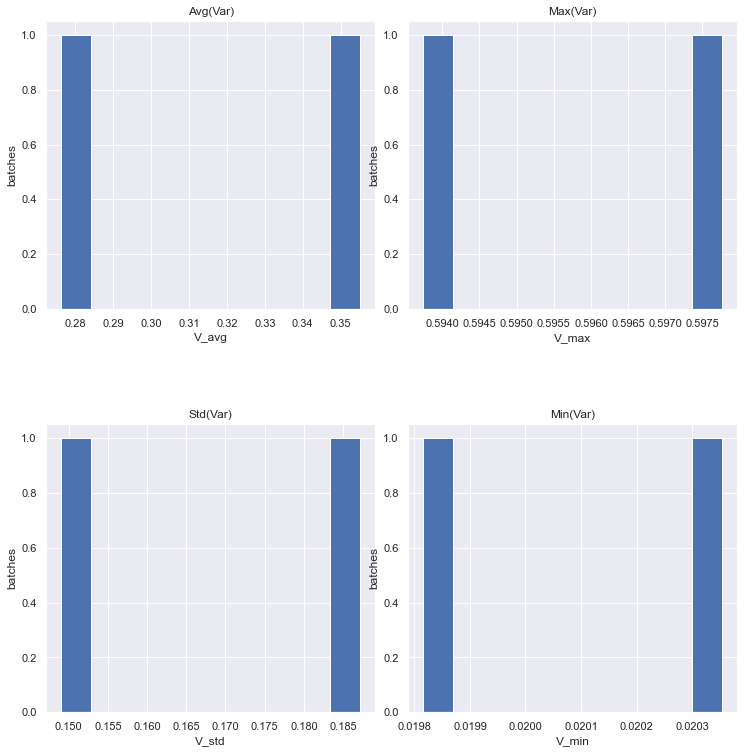

`stopped


In [3]:
import time
from IPython.display import clear_output

start_time = time.time()

try:
    # There are about 220,000 features, so we can loop <= 110 times.
    csvBatchSize = 2001
    maxIteration = 2

    V_info = {}
    ps = []
    V_info["avg"] = np.empty(maxIteration + 1) 
    V_info["std"] = np.empty(maxIteration + 1) 
    V_info["max"] = np.empty(maxIteration + 1) 
    V_info["min"] = np.empty(maxIteration + 1) 

    for csvBatch_idx, csvBatch in enumerate(pd.read_csv("gtTypes.csv", chunksize=csvBatchSize)):
        data = csvBatch
        # current_time = time.time() - start_time
        # print(f"{current_time:.2f}")
        X = data.values[:, 1:].astype(float).T

        varAnalysisInfo = varAnalysis(X=X)
        V_info["avg"][csvBatch_idx], V_info["std"][csvBatch_idx] = varAnalysisInfo[:2]
        V_info["max"][csvBatch_idx], V_info["min"][csvBatch_idx] = varAnalysisInfo[2:]
        
        # Dynamically plot variance distributions
        V_info_sofar = {} 
        for key in V_info:
            V_info_sofar[key] = V_info[key][:csvBatch_idx + 1]
        clear_output(wait=True)
        print(f"----------\ncsvBatch: {csvBatch_idx}")
        plot_V_info(V_info_sofar)
        
        # Store p-values
        
        if csvBatch_idx == maxIteration:
            break
            
except KeyboardInterrupt:
    print("`stopped")

In [5]:
V_info 

{'avg': array([3.55198114e-001, 2.76203817e-001, 6.47591605e-319]),
 'std': array([0.18720089, 0.14902071, 0.        ]),
 'max': array([0.5977667 , 0.59374164, 0.        ]),
 'min': array([0.01981568, 0.02035444, 0.        ])}

In [6]:
varAnalysis(X=X)

(0.2762038167256483,
 0.14902070909246662,
 0.5937416361570463,
 0.020354437571013382)

----

## Process Targets

In [84]:
df = pd.read_csv("targets.csv")

# targetRatIDs = df['RatID'].values
targetRatIDs = df.loc[(df["Vendor"] == "Charles River")]["RatID"].values.astype(int)
miceIDs = np.array(data.columns)[1:].astype(int)

df.head()

,RatID,Sex,Vendor,Vendor Location,Barrier,Experimenter(s),Phenotype,Date (Birth),Date (Training Day 1),Age,Weight,Housing,Light Cycle,Additional Notes,Shipment (Month [Year]),Box
0,1,M,Harlan,"Haslett, MI",206,LMY,GT,16-12-11,21-02-12,67,250,Single,Standard,NaN,October (2012),?
1,2,M,Harlan,"Haslett, MI",206,LMY,ST,16-12-11,21-02-12,67,250,Single,Standard,NaN,October (2012),?
2,3,M,Harlan,"Haslett, MI",206,LMY,GT,16-12-11,21-02-12,67,250,Single,Standard,NaN,October (2012),?
3,4,M,Harlan,"Haslett, MI",206,LMY,ST,16-12-11,21-02-12,67,250,Single,Standard,NaN,October (2012),?
4,5,M,Harlan,"Haslett, MI",206,LMY,GT,16-12-11,21-02-12,67,250,Single,Standard,NaN,October (2012),?


In [93]:
targetRatIDs.size

2335

In [94]:
miceIDs.size

1780

In [86]:
a, b = set(targetRatIDs), set(miceIDs)
len(a.intersection(b))

1780

In [89]:
df[df.columns[0]].values[miceIDs-498]

array([ 671,  672,  675, ..., 4362, 4923,  524], dtype=int64)

In [88]:
np.max(miceIDs), np.min(miceIDs)

(5703, 162)

In [87]:
miceIDs

array([1052, 1053, 1054, ..., 4182, 4659,  920])

----

## Get p values

In [22]:
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings('ignore')

# !pip install statsmodels
import statsmodels.api as sm

In [23]:

X = data.values[:, 1:].astype(float).T

rng = np.random.RandomState(7)
Y = rng.randint(0,2, X.shape[0]).reshape(-1,1)

items, coefs, ps = [], [], []
try:
    for row in X.T:
        x = row.reshape(-1, 1)
        model = SGDClassifier(loss='log')
        model.fit(x, Y)
        y_pred = model.predict(x)
        items.append(y_pred)
        coefs.append(model.coef_[0,0])
        sm_model = sm.Logit(Y, sm.add_constant(x)).fit(disp=0)
        ps.append(sm_model.pvalues[1])
        
except KeyboardInterrupt:
    print("stopped")

In [26]:
# compare with statsmodels
import statsmodels.api as sm
# print(sm.add_constant(x))

# print(pd.Series(sm.add_constant(x)[:, 1]).value_counts())

sm_model = sm.Logit(Y, sm.add_constant(x)).fit(disp=0)
print(sm_model.pvalues[1])

2.0    1200
1.0     516
0.0      64
dtype: int64
0.16658555261209174


- Jie Yuan1:26 PM https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
- Jie Yuan1:30 PM https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
- McKelvey & Zavoina https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/

0.09355327625915083

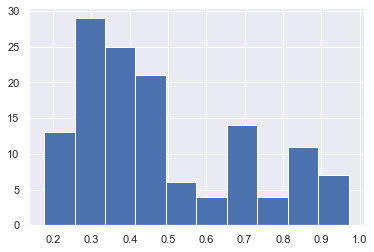

In [256]:
ps = np.abs(ps)
plt.hist(ps);
np.percentile(np.abs(coefs), 25)

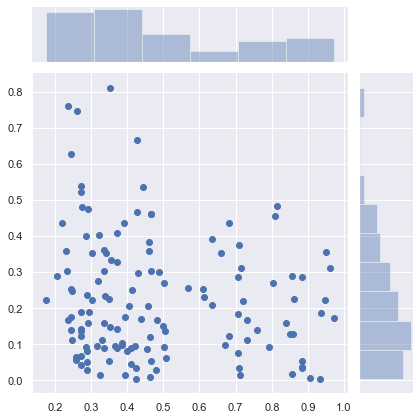

In [258]:
import seaborn as sns; sns.set()

sns.jointplot(ps, coefs, kind="scatter")

0.09355327625915083

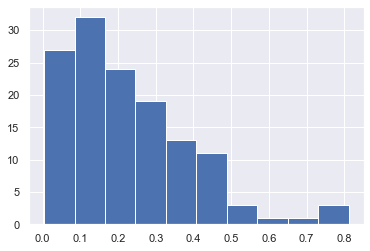

In [257]:
coefs = np.abs(coefs)
plt.hist(coefs);
np.percentile(np.abs(coefs), 25)